In [3]:
    import pandas as pd
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from sklearn.preprocessing import LabelEncoder
    from sklearn.ensemble import RandomForestClassifier

    df = pd.read_csv("songkhla_weather_2024_01.csv")

    # รวม date + time
    df['datetime'] = pd.to_datetime(df['date'] + " " + df['time'])
    df = df.set_index('datetime')

    # ทำความสะอาดตัวเลข
    df['temperature_F'] = df['temperature_F'].str.replace(" °F","").astype(float)
    df['humidity_%'] = df['humidity_%'].str.replace("%","").astype(float)
    df['pressure_in'] = df['pressure_in'].str.replace(" in","").astype(float)


    # Forecast ตัวเลขด้วย SARIMA 
    model_temp = SARIMAX(df['temperature_F'], order=(2,1,2), seasonal_order=(1,1,1,24))
    result_temp = model_temp.fit(disp=False)

    forecast_temp = result_temp.get_forecast(steps=168)  # 1 สัปดาห์
    temp_pred = forecast_temp.predicted_mean

    # ทำนาย condition แปลง condition เป็นตัวเลข
    encoder = LabelEncoder()
    df['condition_label'] = encoder.fit_transform(df['condition'])

    # สร้าง features
    features = df[['temperature_F','humidity_%','pressure_in']].shift(1).dropna()
    labels = df['condition_label'].iloc[1:]

    X_train, y_train = features, labels
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    # ใช้ค่าที่ forecast ได้มาเป็น input
    future_features = pd.DataFrame({
        'temperature_F': temp_pred.values,
        'humidity_%': df['humidity_%'].iloc[-168:].values,   # (ต้อง forecast ด้วย SARIMA เช่นกัน)
        'pressure_in': df['pressure_in'].iloc[-168:].values, # (ต้อง forecast ด้วย SARIMA เช่นกัน)
    })

    condition_pred = encoder.inverse_transform(clf.predict(future_features))

    # 4) รวมผลลัพธ์
    future_df = pd.DataFrame({
        'datetime': pd.date_range(df.index[-1] + pd.Timedelta(hours=1), periods=168, freq="H"),
        'temperature_pred': temp_pred.values,
        'condition_pred': condition_pred
    })

    print(future_df.head(24))  # ดูผลลัพธ์ 1 วันแรก


ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
    import pandas as pd
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from sklearn.preprocessing import LabelEncoder
    from sklearn.ensemble import RandomForestClassifier

    df = pd.read_csv("songkhla_weather_2024_01.csv")

    # รวม date + time
    df['datetime'] = pd.to_datetime(df['date'] + " " + df['time'])
    df = df.set_index('datetime')

    # ทำความสะอาดตัวเลข
    df['temperature_F'] = df['temperature_F'].str.replace(" °F","").astype(float)
    df['humidity_%'] = df['humidity_%'].str.replace("%","").astype(float)
    df['pressure_in'] = df['pressure_in'].str.replace(" in","").astype(float)


    # Forecast ตัวเลขด้วย SARIMA 
    model_temp = SARIMAX(df['temperature_F'], order=(2,1,2), seasonal_order=(1,1,1,24))
    result_temp = model_temp.fit(disp=False)

    forecast_temp = result_temp.get_forecast(steps=168)  # 1 สัปดาห์
    temp_pred = forecast_temp.predicted_mean

    # ทำนาย condition แปลง condition เป็นตัวเลข
    encoder = LabelEncoder()
    df['condition_label'] = encoder.fit_transform(df['condition'])

    # สร้าง features
    features = df[['temperature_F','humidity_%','pressure_in']].shift(1).dropna()
    labels = df['condition_label'].iloc[1:]

    X_train, y_train = features, labels
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    # ใช้ค่าที่ forecast ได้มาเป็น input
    future_features = pd.DataFrame({
        'temperature_F': temp_pred.values,
        'humidity_%': df['humidity_%'].iloc[-168:].values,   # (ต้อง forecast ด้วย SARIMA เช่นกัน)
        'pressure_in': df['pressure_in'].iloc[-168:].values, # (ต้อง forecast ด้วย SARIMA เช่นกัน)
    })

    condition_pred = encoder.inverse_transform(clf.predict(future_features))

    # 4) รวมผลลัพธ์
    future_df = pd.DataFrame({
        'datetime': pd.date_range(df.index[-1] + pd.Timedelta(hours=1), periods=168, freq="H"),
        'temperature_pred': temp_pred.values,
        'condition_pred': condition_pred
    })

    print(future_df.head(24))  # ดูผลลัพธ์ 1 วันแรก


ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
# ==============================
# 5) Visualization (Matplotlib)
# ==============================
import matplotlib.pyplot as plt

# --- ตั้งค่าพื้นฐาน ---
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

# 5.1 กราฟอุณหภูมิ: ย้อนหลัง 7 วัน + คาดการณ์ 7 วัน
hist_hours = 24 * 7
hist_temp = df['temperature_F'].iloc[-hist_hours:]
future_temp = pd.Series(temp_pred.values,
                        index=pd.date_range(df.index[-1] + pd.Timedelta(hours=1),
                                            periods=len(temp_pred), freq='H'))

plt.figure()
plt.plot(hist_temp.index, hist_temp.values, label="Temperature (History)")
plt.plot(future_temp.index, future_temp.values, label="Temperature (Forecast)")
plt.title("Temperature: Last 7 Days & Next 7 Days")
plt.xlabel("Datetime")
plt.ylabel("°F")
plt.legend()
plt.tight_layout()
plt.show()

# 5.2 กราฟความชื้น (ถ้าคุณมี forecast ให้แทนที่ด้วยซีรีส์ที่คาดการณ์)
hist_hum = df['humidity_%'].iloc[-hist_hours:]
future_hum = pd.Series(df['humidity_%'].iloc[-168:].values,
                       index=pd.date_range(df.index[-1] + pd.Timedelta(hours=1),
                                           periods=168, freq='H'))

plt.figure()
plt.plot(hist_hum.index, hist_hum.values, label="Humidity (History)")
plt.plot(future_hum.index, future_hum.values, label="Humidity (Future Input)")
plt.title("Humidity: Last 7 Days & Future (used as input)")
plt.xlabel("Datetime")
plt.ylabel("%")
plt.legend()
plt.tight_layout()
plt.show()

# 5.3 กราฟความกดอากาศ (ถ้าคุณมี forecast ให้แทนที่ด้วยซีรีส์ที่คาดการณ์)
hist_pres = df['pressure_in'].iloc[-hist_hours:]
future_pres = pd.Series(df['pressure_in'].iloc[-168:].values,
                        index=pd.date_range(df.index[-1] + pd.Timedelta(hours=1),
                                            periods=168, freq='H'))

plt.figure()
plt.plot(hist_pres.index, hist_pres.values, label="Pressure (History)")
plt.plot(future_pres.index, future_pres.values, label="Pressure (Future Input)")
plt.title("Pressure: Last 7 Days & Future (used as input)")
plt.xlabel("Datetime")
plt.ylabel("inHg")
plt.legend()
plt.tight_layout()
plt.show()

# 5.4 ไทม์ไลน์ condition แบบเชิงหมวดหมู่ (แปลงเป็นตัวเลขเพื่อพล็อต)
#     - ใช้ encoder ที่คุณฝึกไว้ เพื่อ mapping ชื่อ -> เลข และ เลข -> ชื่อ
#     - สร้างซีรีส์ตัวเลขตามค่าพยากรณ์
cond_to_label = {cls: i for i, cls in enumerate(encoder.classes_)}  # ชื่อ -> เลข
label_to_cond = {i: cls for i, cls in enumerate(encoder.classes_)}  # เลข -> ชื่อ

cond_num = [cond_to_label[c] for c in condition_pred]
cond_num_series = pd.Series(cond_num, index=future_df['datetime'])

plt.figure()
plt.step(cond_num_series.index, cond_num_series.values, where='post')
plt.yticks(ticks=list(label_to_cond.keys()),
           labels=[label_to_cond[i] for i in label_to_cond.keys()])
plt.title("Forecasted Condition (Timeline)")
plt.xlabel("Datetime")
plt.ylabel("Condition")
plt.tight_layout()
plt.show()

# 5.5 นับจำนวนแต่ละ condition ใน 7 วันถัดไป (กราฟแท่ง)
cond_counts = pd.Series(condition_pred).value_counts().sort_index()

plt.figure()
plt.bar(cond_counts.index, cond_counts.values)
plt.title("Condition Counts (Next 7 Days)")
plt.xlabel("Condition")
plt.ylabel("Count (hours)")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# 5.6 สรุปตารางค่าคาดการณ์ 1 วันแรกเพื่อดูเร็วๆ (แสดงหัวตาราง)
print("\n[Preview: Forecast next 24 hours]")
print(future_df.head(24))

# (ถ้าต้องการบันทึกเป็นไฟล์ภาพ ให้เพิ่มบรรทัดต่อไปนี้หลังแต่ละกราฟ)
# plt.savefig("temperature_forecast.png", dpi=150)


C:\Users\sakka\AppData\Local\Temp\ipykernel_14304\2418743858.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['date'] + " " + df['time'])


Epoch 1/50
438/438 [==============================] - 9s 15ms/step - loss: 0.0121 - val_loss: 0.0040
Epoch 2/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 3/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 4/50
438/438 [==============================] - 5s 11ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 5/50
438/438 [==============================] - 5s 11ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/50
438/438 [==============================] - 5s 11ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 7/50
438/438 [==============================] - 5s 11ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/50
438/438 [==============================] - 5s 11ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/50
438/438 [==============================] - 5s 11ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 10/50
438/438 [==============================] - 4s 10ms/step - loss: 0.0020 - val_lo

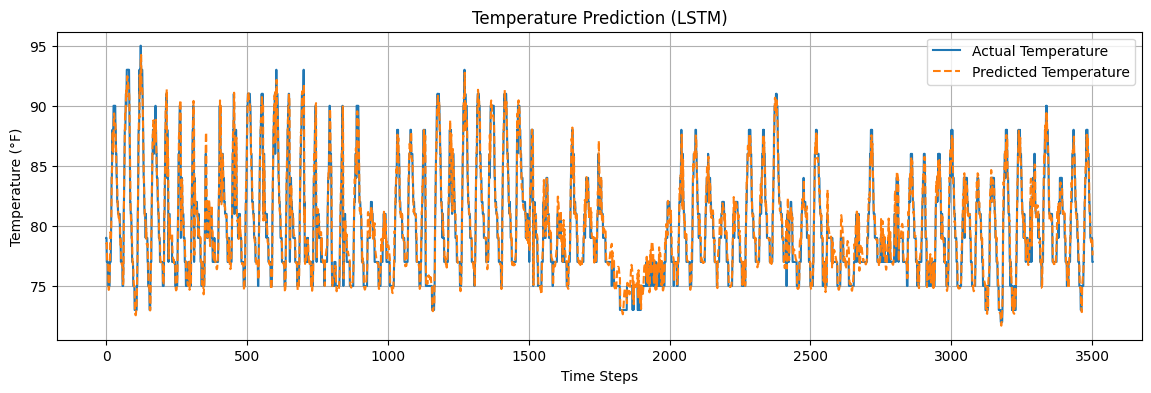

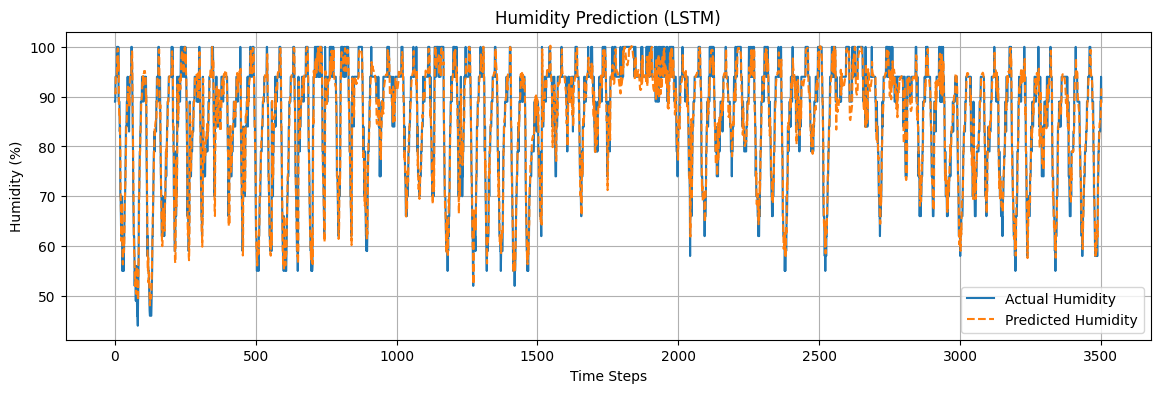

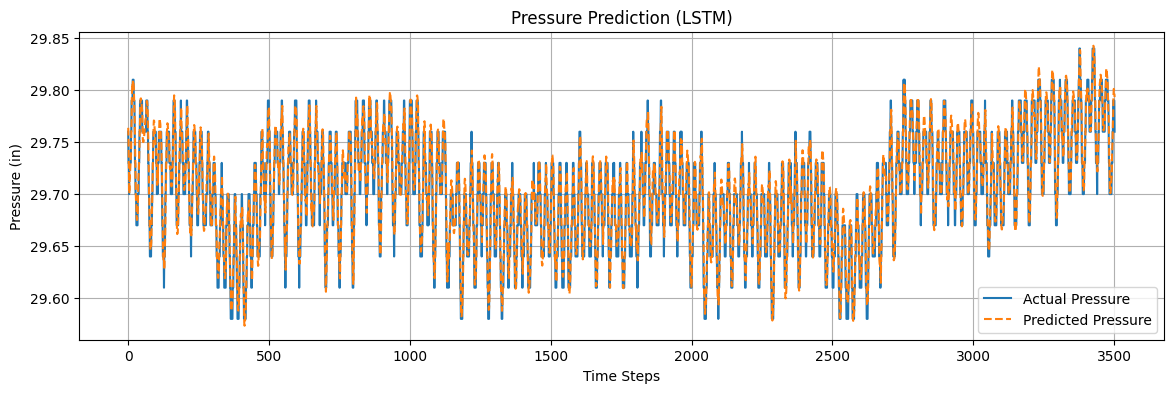

✅ LSTM model saved to lstm_weather.h5


c:\Users\sakka\Documents\Years3\venv310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

df = pd.read_csv("songkhla_weather_2024_01.csv")

# datetime
df['datetime'] = pd.to_datetime(df['date'] + " " + df['time'])
df = df.set_index('datetime')

# clean
df['temperature_F'] = df['temperature_F'].str.replace(" °F","").astype(float)
df['humidity_%'] = df['humidity_%'].str.replace("%","").astype(float)
df['pressure_in'] = df['pressure_in'].str.replace(" in","").astype(float)

data = df[['temperature_F','humidity_%','pressure_in']].values

# scale
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# สร้าง sequence
def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 24
X, y = create_sequences(data_scaled, seq_len)

# split train/test
train_size = int(len(X)*0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# สร้างโมเดล LSTM
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(seq_len, 3)))
model.add(Dense(3))  # temp, humidity, pressure
model.compile(optimizer='adam', loss='mse')

# เทรน
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)

# ทำนาย
y_pred = model.predict(X_test)

# inverse scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# คำนวณ MSE
from sklearn.metrics import mean_squared_error

mse_temp = mean_squared_error(y_test_inv[:,0], y_pred_inv[:,0])
mse_hum  = mean_squared_error(y_test_inv[:,1], y_pred_inv[:,1])
mse_pres = mean_squared_error(y_test_inv[:,2], y_pred_inv[:,2])

print("MSE Temperature:", mse_temp)
print("MSE Humidity:", mse_hum)
print("MSE Pressure:", mse_pres)

# Save Model Visualization

plt.figure(figsize=(14, 4))
plt.plot(y_test_inv[:, 0], label="Actual Temperature")
plt.plot(y_pred_inv[:, 0], label="Predicted Temperature", linestyle="--")
plt.title("Temperature Prediction (LSTM)")
plt.xlabel("Time Steps")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y_test_inv[:, 1], label="Actual Humidity")
plt.plot(y_pred_inv[:, 1], label="Predicted Humidity", linestyle="--")
plt.title("Humidity Prediction (LSTM)")
plt.xlabel("Time Steps")
plt.ylabel("Humidity (%)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y_test_inv[:, 2], label="Actual Pressure")
plt.plot(y_pred_inv[:, 2], label="Predicted Pressure", linestyle="--")
plt.title("Pressure Prediction (LSTM)")
plt.xlabel("Time Steps")
plt.ylabel("Pressure (in)")
plt.legend()
plt.grid(True)
plt.show()

model.save("lstm_weather.h5")
print("✅ LSTM model saved to lstm_weather.h5")


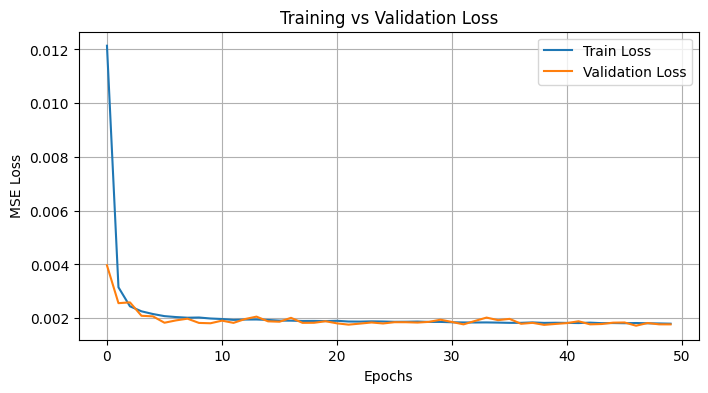

In [3]:
# Plot training vs validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


                     temperature_F_pred  humidity_%_pred  pressure_in_pred
2025-01-01 00:30:00           76.754089        90.880760         29.771191
2025-01-01 01:30:00           76.517578        91.741150         29.766397
2025-01-01 02:30:00           76.236671        92.385933         29.758947
2025-01-01 03:30:00           76.008286        93.043480         29.751303
2025-01-01 04:30:00           75.813026        93.637596         29.744162
                     temperature_F_pred  humidity_%_pred  pressure_in_pred
2025-01-07 19:30:00           86.482506        66.022224         29.884823
2025-01-07 20:30:00           87.208191        63.132812         29.880707
2025-01-07 21:30:00           87.760704        60.701168         29.875187
2025-01-07 22:30:00           88.149429        58.774239         29.868603
2025-01-07 23:30:00           88.377708        57.375664         29.861332


C:\Users\sakka\AppData\Local\Temp\ipykernel_14304\996021532.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1),


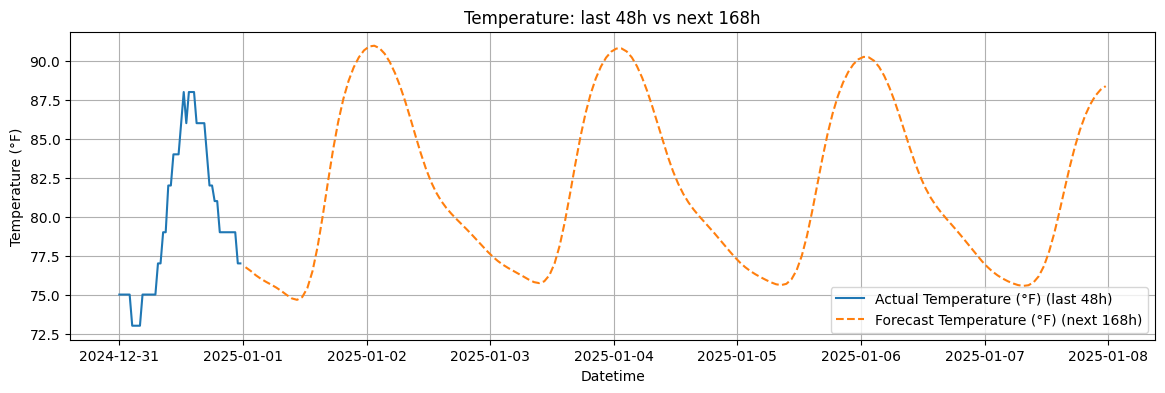

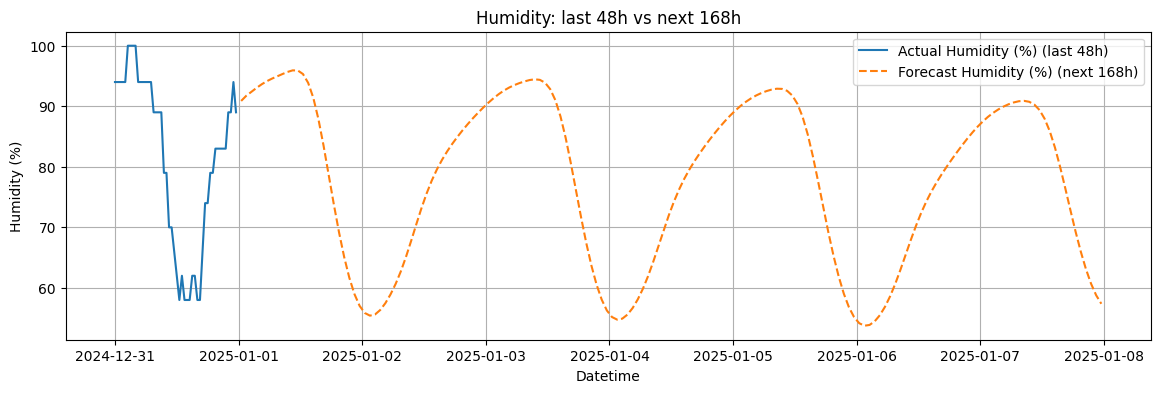

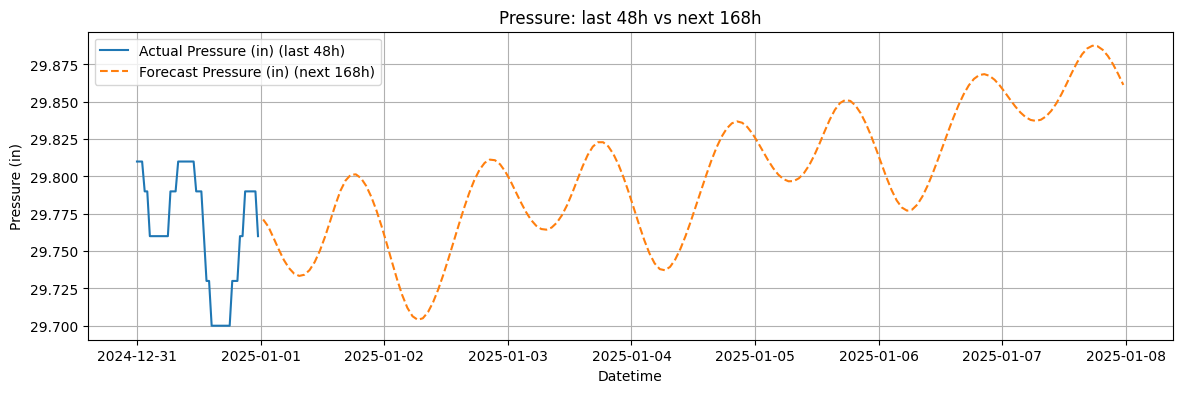

In [4]:
# ===== 1 สัปดาห์ข้างหน้า (168 ชั่วโมง) ด้วย LSTM แบบ recursive =====
future_hours = 24 * 7  # 1 สัปดาห์
seq = seq_len          # ใช้ seq_len เดิมที่คุณตั้งไว้ (เช่น 24)

# 1) หน้าต่างล่าสุดจากข้อมูลสเกลแล้ว
last_window = data_scaled[-seq:].copy()            # shape = (seq, 3)
window = last_window.reshape(1, seq, 3)            # (1, seq, 3)

future_scaled_preds = []

for _ in range(future_hours):
    # ทำนายทีละ 1 ชั่วโมงข้างหน้า
    next_scaled = model.predict(window, verbose=0)           # (1, 3)
    future_scaled_preds.append(next_scaled[0])

    # เลื่อนหน้าต่าง: ตัดตัวแรกทิ้ง แล้วต่อผลทำนายท้าย
    window = np.concatenate([window[:, 1:, :],
                             next_scaled.reshape(1, 1, 3)], axis=1)

future_scaled_preds = np.array(future_scaled_preds)          # (168, 3)

# 2) แปลงกลับเป็นสเกลจริง
future_preds_inv = scaler.inverse_transform(future_scaled_preds)  # (168, 3)

# 3) สร้าง index เวลาอนาคต (รายชั่วโมง ต่อจากแถวสุดท้ายของ df)
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1),
                             periods=future_hours, freq='H')

# 4) รวมเป็น DataFrame
future_df = pd.DataFrame(future_preds_inv, index=future_index,
                         columns=['temperature_F_pred', 'humidity_%_pred', 'pressure_in_pred'])

print(future_df.head())
print(future_df.tail())

# 5) เซฟเป็น CSV
# future_df.to_csv("lstm_1week_forecast.csv", encoding="utf-8-sig")
# print("✅ Saved 1-week forecast to lstm_1week_forecast.csv")

# 6) Visualization: เทียบ 'ค่าจริงช่วงท้าย' กับ 'อนาคตที่ทำนาย'
def plot_future(var_actual, var_pred, title, ylabel, tail_hours=48):
    plt.figure(figsize=(14,4))
    # ช่วงท้ายจริง 2 วันล่าสุด (ถ้ามี)
    plt.plot(df.index[-tail_hours:], df[var_actual].values[-tail_hours:],
             label=f"Actual {ylabel} (last {tail_hours}h)")
    # อนาคต 1 สัปดาห์
    plt.plot(future_df.index, future_df[var_pred].values, linestyle="--",
             label=f"Forecast {ylabel} (next {future_hours}h)")
    plt.title(title); plt.xlabel("Datetime"); plt.ylabel(ylabel)
    plt.legend(); plt.grid(True); plt.show()

plot_future('temperature_F', 'temperature_F_pred',
            "Temperature: last 48h vs next 168h", "Temperature (°F)")

plot_future('humidity_%', 'humidity_%_pred',
            "Humidity: last 48h vs next 168h", "Humidity (%)")

plot_future('pressure_in', 'pressure_in_pred',
            "Pressure: last 48h vs next 168h", "Pressure (in)")
